In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# Define the path to the ZIP file in Google Drive
zip_path = "/content/drive/MyDrive/Weather_Image_Dataset.zip"  # Change to your actual ZIP file path
extract_path = "/content/Weather"  # Change to desired extraction location

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")


Files extracted to: /content/Weather


In [ ]:
import os
import shutil
from sklearn.utils import resample

def balance_dataset(original_dir, balanced_dir):
    """
    Create a balanced dataset by oversampling the minority classes.

    Args:
        original_dir (str): Path to original dataset (folder with subfolders for each class).
        balanced_dir (str): Path to output the balanced dataset.
    """
    if not os.path.exists(balanced_dir):
        os.makedirs(balanced_dir)

    class_counts = {}
    max_class_size = 0

    # Step 1: Count images in each class
    for class_name in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_name)
        if os.path.isdir(class_path):
            images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
            class_counts[class_name] = images
            max_class_size = max(max_class_size, len(images))

    # Step 2: Copy images and oversample minority classes
    for class_name, images in class_counts.items():
        class_input_path = os.path.join(original_dir, class_name)
        class_output_path = os.path.join(balanced_dir, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        # Copy original images
        for img in images:
            src = os.path.join(class_input_path, img)
            dst = os.path.join(class_output_path, img)
            shutil.copyfile(src, dst)

        # Oversample if needed
        if len(images) < max_class_size:
            extra_images = resample(images, replace=True, n_samples=max_class_size - len(images), random_state=42)
            for i, img_name in enumerate(extra_images):
                src = os.path.join(class_input_path, img_name)
                new_name = f"dup_{i}_{img_name}"
                dst = os.path.join(class_output_path, new_name)
                shutil.copyfile(src, dst)

    print(f"Dataset balanced. All classes now have {max_class_size} images.")

# Example usage:
original_dataset_path = "/content/Weather/dataset"              # Your original dataset path
balanced_dataset_path = "/content/Weather/balanced_dataset"     # New balanced dataset path

balance_dataset(original_dataset_path, balanced_dataset_path)


Dataset balanced. All classes now have 1160 images.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np

# Data Augmentation with Validation Split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split data into 80% training and 20% validation
)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    balanced_dataset_path,  # Path to your balanced dataset
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    balanced_dataset_path,  # Path to your balanced dataset
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Build the model after train_generator is defined
model = keras.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer using num_classes
])


Found 10208 images belonging to 11 classes.
Found 2552 images belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    balanced_dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    balanced_dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 10208 images belonging to 11 classes.
Found 2552 images belonging to 11 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,567,179 (36.50 MB)

 Trainable params: 9,566,731 (36.49 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 118s 341ms/step - accuracy: 0.4088 - loss: 4.3738 - val_accuracy: 0.2418 - val_loss: 7.1516
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 103s 324ms/step - accuracy: 0.4881 - loss: 1.6166 - val_accuracy: 0.5321 - val_loss: 1.4035
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 103s 322ms/step - accuracy: 0.5408 - loss: 1.3738 - val_accuracy: 0.6403 - val_loss: 1.0609
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 104s 328ms/step - accuracy: 0.5869 - loss: 1.2303 - val_accuracy: 0.6117 - val_loss: 1.3519
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 101s 318ms/step - accuracy: 0.5984 - loss: 1.1979 - val_accuracy: 0.5372 - val_loss: 1.5391
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 102s 321ms/step - accuracy: 0.6082 - loss: 1.1482 - val_accuracy: 0.6658 - val_loss: 1.1217
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 104s 325ms/step - accuracy: 0.6309 - loss: 1.0971 - val_accuracy: 0.5811 - val_loss: 1.3417
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 102s 319ms/step - accuracy: 0.6460 -

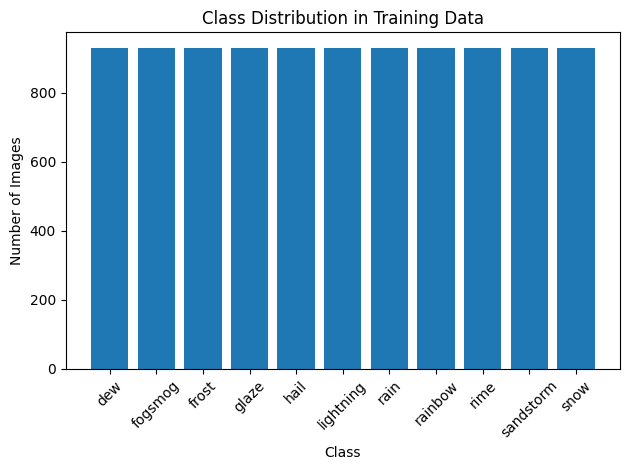

In [ ]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Compute class weights
labels, counts = np.unique(train_generator.classes, return_counts=True)
class_weights = compute_class_weight('balanced', classes=np.array(labels), y=train_generator.classes)
class_weights_dict = {i: class_weights[i] for i in range(len(labels))}

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights_dict
)

# Plot class distribution
plt.bar(labels, counts, tick_label=list(train_generator.class_indices.keys()))
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
model.save('my_cnn_model.h5')

In [ ]:
predictions = model.predict(val_generator)
predictions = np.argmax(predictions, axis = 1)

80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step


In [ ]:
test_accuracy = model.evaluate(val_generator)[1] * 100

80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 271ms/step - accuracy: 0.7971 - loss: 1.0972


In [ ]:
train_accuracy = history.history['accuracy'][-1]
print(train_accuracy)

0.8885188102722168


In [ ]:
import numpy as np

y_true = []
y_pred = []  # To store predictions for each batch

for _ in range(len(val_generator)):
    x, y = val_generator.__next__()
    y_true.extend(np.argmax(y, axis=1))  # True labels for the batch

    # Get predictions for the current batch
    batch_predictions = model.predict(x)
    batch_predictions = np.argmax(batch_predictions, axis=1)
    y_pred.extend(batch_predictions)

for i in range(len(y_true)):
    print(f"Sample {i}: True Label = {y_true[i]}, Predicted Label = {y_pred[i]}")
    if y_true[i] == y_pred[i]:
        print("Correct prediction!")
    else:
        print("Incorrect prediction.")
    print("-" * 20)  # Separator

Streaming output truncated to the last 5000 lines.
Correct prediction!
--------------------
Sample 886: True Label = 0, Predicted Label = 0
Correct prediction!
--------------------
Sample 887: True Label = 2, Predicted Label = 3
Incorrect prediction.
--------------------
Sample 888: True Label = 5, Predicted Label = 5
Correct prediction!
--------------------
Sample 889: True Label = 2, Predicted Label = 2
Correct prediction!
--------------------
Sample 890: True Label = 2, Predicted Label = 3
Incorrect prediction.
--------------------
Sample 891: True Label = 2, Predicted Label = 8
Incorrect prediction.
--------------------
Sample 892: True Label = 1, Predicted Label = 1
Correct prediction!
--------------------
Sample 893: True Label = 9, Predicted Label = 9
Correct prediction!
--------------------
Sample 894: True Label = 1, Predicted Label = 1
Correct prediction!
--------------------
Sample 895: True Label = 0, Predicted Label = 0
Correct prediction!
--------------------
Sample 896: 

In [ ]:
import numpy as np

# Get all true labels and predictions from the validation generator
y_true = []
y_pred = []

for _ in range(len(val_generator)):
    x, y = val_generator.__next__()
    y_true.extend(np.argmax(y, axis=1))

    batch_predictions = model.predict(x)
    batch_predictions = np.argmax(batch_predictions, axis=1)
    y_pred.extend(batch_predictions)

# Initialize counters
correct_predictions = 0
incorrect_predictions = 0

# Compare and count
for true_label, predicted_label in zip(y_true, y_pred):
    if true_label == predicted_label:
        correct_predictions += 1
    else:
        incorrect_predictions += 1

# Print the results
print(f"Total Predictions: {len(y_true)}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━

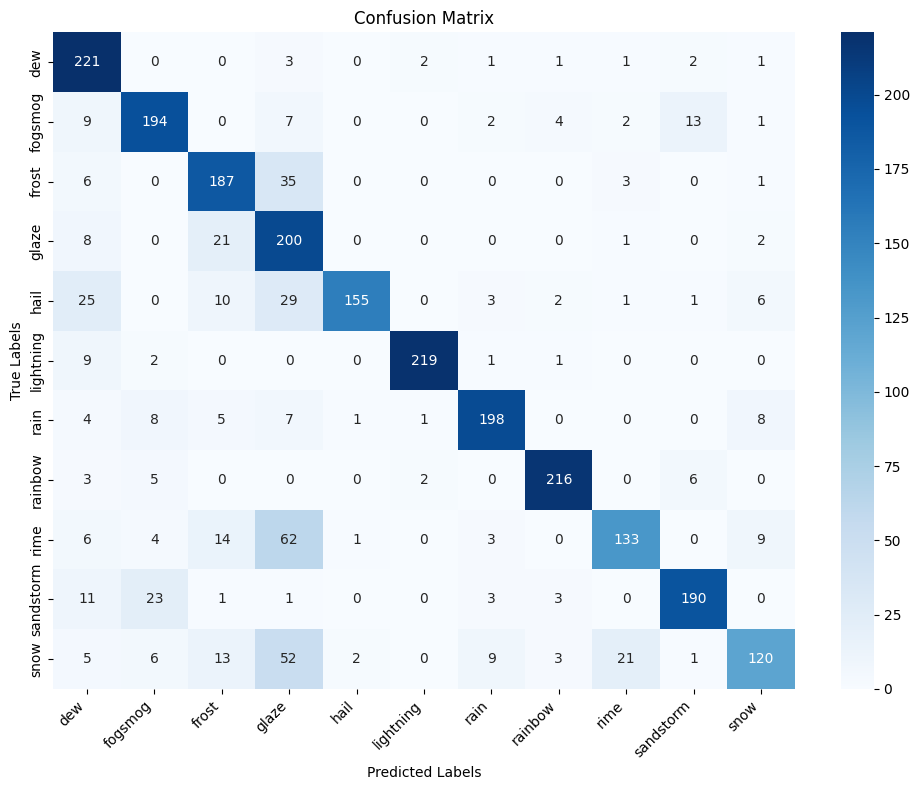

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get all true labels and predictions from the validation generator
y_true = []
y_pred = []

for _ in range(len(val_generator)):
    x, y = val_generator.__next__()
    y_true.extend(np.argmax(y, axis=1))

    batch_predictions = model.predict(x)
    batch_predictions = np.argmax(batch_predictions, axis=1)
    y_pred.extend(batch_predictions)

# Generate classification report
class_names = list(train_generator.class_indices.keys()) # Get class names from train_generator
report = classification_report(y_true, y_pred, target_names=class_names)  # Using y_pred
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)  # Using y_pred

# Create a heatmap for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import norm  # Import norm for CDF calculation

train_samples = len(train_generator.classes)  # Number of samples in training set
test_samples = len(val_generator.classes)   # Number of samples in validation set


def z_test(p1, p2, n1, n2):
    p_combined = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    return z_score, p_value

z_score, p_value = z_test(train_accuracy, test_accuracy, train_samples, test_samples)
print(f"Z-score: {z_score:.4f}, P-value: {p_value:.4f}")

# Interpret results
if p_value < 0.05:
    print("Significant difference between train and test accuracy (p < 0.05). Model may be overfitting.")
else:
    print("No significant difference between train and test accuracy.")

Z-score: nan, P-value: nan
No significant difference between train and test accuracy.


<ipython-input-31-5dfcb9626c19>:11: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))


In [ ]:
t_stat, t_p_value = ttest_ind(history.history['accuracy'], history.history['val_accuracy']) # Now you can use ttest_ind
print(f"T-test Statistic: {t_stat:.4f}, P-value: {t_p_value:.4f}")

T-test Statistic: 2.0116, P-value: 0.0470


In [ ]:
from scipy.stats import f_oneway

anova_stat, anova_p_value = f_oneway(history.history['accuracy'], history.history['val_accuracy'])
print(f"ANOVA F-statistic: {anova_stat:.4f}, P-value: {anova_p_value:.4f}")

if anova_p_value < 0.05:
    print("Significant differences exist between training and validation accuracy over epochs.")
else:
    print("No significant differences between training and validation accuracy.")

ANOVA F-statistic: 4.0467, P-value: 0.0470
Significant differences exist between training and validation accuracy over epochs.
